In [2]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import lux
import matplotlib.pyplot as plt
%matplotlib inline

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor': 'white',
                     'figure.edgecolor': 'white',
                     'axes.grid': True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 1         # rows
m = corrected_key_bits = 50 # columns
N_vec = 10000               # nº of corrected key vectors

## Functions

### Detect power consumption of basic operations

In [4]:
# def get_product_power(mat, vec, op_powers):
#     '''
#     Returns: count[0] -> 0*0 power
#              count[1] -> 0*1 power
#              count[2] -> 1*0 power
#              count[3] -> 1*1 power
#     '''
#     n, m = mat.shape
#     count = np.zeros((4, n, m))
#     for i in range(n):
#         for j in range(m):
#             if not mat[i, j] and not vec[j]:
#                 count[0, i, j] = 1
#             if not mat[i, j] and vec[j]:
#                 count[1, i, j] = 1
#             if mat[i, j] and not vec[j]:
#                 count[2, i, j] = 1
#             if mat[i, j] and vec[j]:
#                 count[3, i, j] = 1
#     return np.asarray([(count[i] * power).ravel() for i, power in enumerate(op_powers)])

# Cooler version :)
def get_product_power(mat, vec, op_powers):
    '''Returns: array with the power of each product.'''
    n, m = mat.shape
    count = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            count[i, j] = op_powers[2 * mat[i, j] + vec[j]]
    return count.ravel()

In [5]:
# def get_sum_power(mat, vec, op_powers):
#     '''
#     Returns: count[0] -> 0+0 power
#              count[1] -> 0+1 power
#              count[2] -> 1+0 power
#              count[3] -> 1+1 power
#     '''
#     n, m = mat.shape
#     count = np.zeros((4, n, m))
#     for i in range(n):
#         result = 0
#         for j in range(m):
#             next_element = mat[i, j] * vec[j]
#             if not result and not next_element:
#                 count[0, i, j] = 1
#             if not result and next_element:
#                 count[1, i, j] = 1
#             if result and not next_element:
#                 count[2, i, j] = 1
#             if result and next_element:
#                 count[3, i, j] = 1
#             result = (result + next_element) % 2
#     return np.asarray([(count[i] * power).ravel() for i, power in enumerate(op_powers)])

# Cooler version :)
def get_sum_power(mat, vec, op_powers):
    '''Returns: array with the power of each sum.'''
    n, m = mat.shape
    count = np.zeros((n, m))
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            count[i, j] = op_powers[2 * result + next_element]
            result = (result + next_element) % 2
    return count.ravel()

In [6]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# vec = np.asarray([1, 1, 1, 1, 1])
# # vec = np.asarray([1, 1, 1, 0, 0])
# n, m = mat.shape

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, [.1, .2, .3, .4])
# for i in range(n): print(count[i*m:(i+1)*m])
# print()
# count = get_sum_power(mat, vec, [1.1, 1.2, 1.3, 1.4])
# for i in range(n): print(count[i*m:(i+1)*m])

### Class

In [7]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [8]:
# Check if output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique = np.unique(res, axis=0, return_counts=True)
    return unique[1].shape[0] == np.shape(vec)[0], unique[1].shape[0]

## Generate data

In [9]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((1, 50),
 array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 0, 1, 1, 0, 0]], dtype=int8))

In [10]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 50),
 array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0], dtype=int8))

In [10]:
print('Are solutions from this sample unique? %s ---> %i unique sols out of %i' % (*Check_uniqueness(mat, vec), N_vec))

Are solutions from this sample unique? False ---> 2 unique sols out of 10000


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA ~ 7 pA
    - 1 - 7.45 pA ~ 7 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7 = 12.79 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7 = 14.00 pA
- 1\*0: &nbsp; 11.77 + 7 = 18.77 pA
- 1\*1: &nbsp; 14.91 + 7 = 21.91 pA


- 0+0: &nbsp; (7 + 7.93 + 7) + (7 + 7.93 + 7) + 14.91 = 58.77 pA
- 0+1: &nbsp; (7 + 5.93 + 7) + (7 + 13.5 + 7) + 11.77 = 59.20 pA
- 1+0: &nbsp; (7 + 13.5 + 7) + (7 + 5.93 + 7) + 7 &nbsp; &nbsp; &nbsp; &nbsp;= 54.43 pA
- 1+1: &nbsp; (7 + 12.8 + 7) + (7 + 12.8 + 7) + 14.91 = 68.51 pA

In [11]:
# Define power consumption for each operation
power_products = np.asarray([12.79,  14., 18.77, 21.91]) # 0*0, 0*1, 1*0, 1*1
power_sums     = np.asarray([58.77, 59.2, 54.43, 68.51]) # 0+0, 0+1, 1+0, 1+1

In [12]:
i = 0
print('Products:', get_product_power(mat, vec[i], power_products))
print('Sums:    ', get_sum_power(mat, vec[i], power_sums))

Products: [18.77 12.79 21.91 14.   18.77 21.91 14.   21.91 21.91 21.91 18.77 21.91
 12.79 14.   12.79 14.   12.79 12.79 21.91 12.79 18.77 14.   21.91 21.91
 18.77 18.77 12.79 12.79 12.79 18.77 18.77 21.91 21.91 21.91 21.91 12.79
 21.91 14.   14.   12.79 18.77 12.79 18.77 21.91 18.77 14.   18.77 21.91
 12.79 12.79]
Sums:     [58.77 58.77 59.2  54.43 54.43 68.51 58.77 59.2  68.51 59.2  54.43 68.51
 58.77 58.77 58.77 58.77 58.77 58.77 59.2  54.43 54.43 54.43 68.51 59.2
 54.43 54.43 54.43 54.43 54.43 54.43 54.43 68.51 59.2  68.51 59.2  54.43
 68.51 58.77 58.77 58.77 58.77 58.77 58.77 59.2  54.43 54.43 54.43 68.51
 58.77 58.77]


In [13]:
print("#1 > #0?")
print("--------")
for i in range(10):
    print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

#1 > #0?
--------
False 	 [0]
True 	 [1]
True 	 [1]
True 	 [1]
True 	 [1]
False 	 [0]
False 	 [0]
True 	 [1]
False 	 [0]
False 	 [0]


In [12]:
# Warning: data is not time-ordered, i.e. row-by-row power
data = [[*get_product_power(mat, vec[i], power_products) - power_products.mean(),
         *get_sum_power(mat, vec[i], power_sums) - power_sums.mean(),
         More_1_than_0(mat, vec[i])] for i in range(N_vec)]
np.shape(data)

(10000, 101)

In [13]:
# Create column labels
row_bits = [str(i // m)+','+str(i % m) for i in range(n * m)]
columns = row_bits + ['+'+row_bits[i] for i in range(n * m)] + ['More_1_than_0']

# Create dataframe
df = pd.DataFrame(data, columns=columns)
df.drop_duplicates(inplace=True, ignore_index=True)
# df

In [14]:
# Drop columns with equal values
def duplicate_columns(df):
    groups = df.columns.to_series().groupby(df.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = df[v].to_dict(orient='list')
        vs = list(dcols.values())
        ks = list(dcols.keys())
        for i in range(len(vs)):
            for j in range(i+1, len(vs)):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break
    if dups: print('Duplicate columns:', *dups)
    return dups

df.drop(duplicate_columns(df), axis=1, inplace=True)
df

Duplicate columns: +0,12 +0,13 +0,14 +0,15 +0,16 +0,26 +0,27 +0,37 +0,38 +0,48


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [79]:
# Check some trends in data (turn off numba engine first)
pd.set_option('compute.use_numba', False)
df2 = df.copy()
df2.intent = ['More_1_than_0']
display(df2)
pd.set_option('compute.use_numba', True)

C:\Users\V082335\Anaconda3\lib\site-packages\IPython\core\formatters.py:918: UserWarning:
Unexpected error in rendering Lux widget and recommendations. Falling back to Pandas display.
Please report the following issue on Github: https://github.com/lux-org/lux/issues 

C:\Users\V082335\Anaconda3\lib\site-packages\lux\core\frame.py:628: UserWarning:Traceback (most recent call last):
  File "C:\Users\V082335\Anaconda3\lib\site-packages\lux\core\frame.py", line 590, in _ipython_display_
    self.maintain_recs()
  File "C:\Users\V082335\Anaconda3\lib\site-packages\lux\core\frame.py", line 432, in maintain_recs
    custom_action_collection = custom_actions(rec_df)
  File "C:\Users\V082335\Anaconda3\lib\site-packages\lux\action\custom.py", line 76, in custom_actions
    recommendation = lux.config.actions[action_name].action(ldf)
  File "C:\Users\V082335\Anaconda3\lib\site-packages\lux\action\enhance.py", line 65, in enhance
    vlist = lux.vis.VisList.VisList(intent, ldf)
  File "C:\Users\V0

,"0,0","0,1","0,2","0,3","0,4","0,5","0,6","0,7","0,8","0,9","0,0+0,1","+0,2","+0,3","+0,4","+0,5","+0,6","+0,7","+0,8","+0,9",More_1_than_0,row0,row0_1/2,row0_2/2,row0_1/3,row0_2/3,row0_3/3,row0_1/5,row0_2/5,row0_3/5,row0_4/5,row0_5/5
0,18.77,12.79,18.77,12.79,18.77,18.77,14.00,18.77,21.91,18.77,58.77,58.77,58.77,58.77,58.77,58.77,58.77,59.20,54.43,True,174.11,81.89,92.22,50.33,50.33,73.45,31.56,31.56,37.54,32.77,40.68
1,21.91,14.00,18.77,12.79,18.77,21.91,14.00,21.91,21.91,21.91,54.43,54.43,54.43,54.43,68.51,58.77,59.20,68.51,59.20,True,187.88,86.24,101.64,54.68,53.47,79.73,35.91,31.56,40.68,35.91,43.82
2,21.91,12.79,18.77,12.79,21.91,18.77,14.00,21.91,21.91,18.77,54.43,54.43,54.43,68.51,58.77,58.77,59.20,68.51,58.77,False,183.53,88.17,95.36,53.47,53.47,76.59,34.70,31.56,40.68,35.91,40.68
3,18.77,12.79,18.77,14.00,18.77,18.77,14.00,21.91,18.77,21.91,58.77,58.77,58.77,58.77,58.77,58.77,59.20,54.43,68.51,False,178.46,83.10,95.36,50.33,51.54,76.59,31.56,32.77,37.54,35.91,40.68
4,21.91,14.00,18.77,14.00,18.77,21.91,12.79,21.91,18.77,18.77,54.43,54.43,54.43,54.43,68.51,58.77,59.20,54.43,54.43,True,181.60,87.45,94.15,54.68,54.68,72.24,35.91,32.77,40.68,34.70,37.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,21.91,12.79,21.91,12.79,18.77,18.77,14.00,21.91,21.91,21.91,54.43,68.51,58.77,58.77,58.77,58.77,59.20,68.51,59.20,True,186.67,88.17,98.50,56.61,50.33,79.73,34.70,34.70,37.54,35.91,43.82
1020,21.91,14.00,18.77,12.79,18.77,18.77,12.79,21.91,21.91,18.77,54.43,54.43,54.43,54.43,54.43,54.43,68.51,59.20,54.43,True,180.39,86.24,94.15,54.68,50.33,75.38,35.91,31.56,37.54,34.70,40.68
1021,21.91,12.79,21.91,14.00,21.91,18.77,14.00,18.77,21.91,18.77,54.43,68.51,58.77,59.20,54.43,54.43,54.43,68.51,58.77,False,184.74,92.52,92.22,56.61,54.68,73.45,34.70,35.91,40.68,32.77,40.68
1022,21.91,12.79,18.77,14.00,21.91,21.91,12.79,18.77,21.91,18.77,54.43,54.43,54.43,68.51,59.20,54.43,54.43,68.51,58.77,False,183.53,89.38,94.15,53.47,57.82,72.24,34.70,32.77,43.82,31.56,40.68


In [486]:
# Generate pandas profiling report
profile = ProfileReport(df, title="More_1s_or_0s Power_per_Op Dataset Report", explorative=True)
# profile.to_widgets()
profile.to_file("Docs/More_1s_or_0s_-_Power_per_Op_report.html")

Summarize dataset:   0%|          | 0/161 [00:00<?, ?it/s]

C:\Users\V082335\Anaconda3\lib\site-packages\pandas\core\series.py:1441: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Split data

In [15]:
# Split data into training & test set
X = np.asarray(df.drop('More_1_than_0', axis=1))
y = np.asarray(df['More_1_than_0'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # used before cross-val

## Classifiers

Models able to to predict with ~100% accuracy:
- Logistic regression
- All SVM
- Gaussian Naïve Bayes
- Decision tree

Models which comparatively suck:
- None

In [17]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    lst_acc = []
    lst_y_pred = [] # not used yet

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)
        lst_acc.append(model.score(x_test_fold, y_test_fold))
        lst_y_pred.append(model.predict(x_test_fold))

    print(f'\nList of accuracies: {lst_acc}')
    print(f'Min/max accuracy:   {min(lst_acc):.2%} <---> {max(lst_acc):.2%}')
    print(f'Mean accuracy:      {np.mean(lst_acc):.2%} +- {np.std(lst_acc):.3%}')
    
    # add more stats
    
    return lst_acc, lst_y_pred

# accuracy_score(y_test, y_pred) # how often is the classifier correct?
# confusion_matrix(y_test, y_pred, normalize='pred') # precision
# confusion_matrix(y_test, y_pred, normalize='true') # recall
# classification_report(y_test, y_pred, output_dict=True)

### Logistic regression

In [21]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1e-1, max_iter=1e5, tol=1e-5, n_jobs=-1, random_state=seed,
                      verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 47 epochs took 0.20 seconds
Convergence after 49 epochs took 0.24 seconds
Convergence after 47 epochs took 0.22 seconds
Convergence after 47 epochs took 0.22 seconds
Convergence after 47 epochs took 0.26 seconds

List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [164]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### SVM

#### Linear kernel

In [22]:
model = SVC(kernel='linear', probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [646]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [329]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1e0, tol=1e-5, n_jobs=-1, random_state=seed, verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 53 epochs took 0.10 seconds
Convergence after 56 epochs took 0.12 seconds
Convergence after 53 epochs took 0.09 seconds
Convergence after 55 epochs took 0.10 seconds
Convergence after 52 epochs took 0.10 seconds

List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [186]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [23]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-5, random_state=seed, verbose=1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [188]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Gaussian kernel

In [43]:
model = SVC(kernel='rbf', gamma='scale', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [42]:
model = SVC(kernel='rbf', gamma='auto', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.701, 0.689, 0.69, 0.6795, 0.698]
Min/max accuracy:   67.95% <---> 70.10%
Mean accuracy:      69.15% +- 0.755%


In [189]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Polynomial kernel

In [347]:
model = SVC(kernel='poly', degree=3, coef0=0., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [334]:
model = SVC(kernel='poly', degree=4, coef0=0., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [657]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Sigmoid kernel

In [45]:
model = SVC(kernel='sigmoid', gamma='scale', coef0=-1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [44]:
model = SVC(kernel='sigmoid', gamma='auto', coef0=-1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5045, 0.5045, 0.504, 0.504, 0.5045]
Min/max accuracy:   50.40% <---> 50.45%
Mean accuracy:      50.43% +- 0.024%


In [658]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Naïve Bayes

#### Gaussian NB

In [24]:
model = GaussianNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [72]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Multinomial NB

In [343]:
model = MultinomialNB() # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

In [43]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Categorical NB

In [253]:
model = CategoricalNB() # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

In [1]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Decision tree

In [18]:
model = DecisionTreeClassifier(max_depth=None,
                               max_features=None,
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.,
                               random_state=seed)

acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
# cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)

model.get_depth(), model.get_n_leaves()


List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


(1, 2)

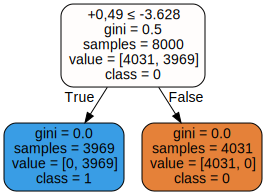

In [19]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=df.columns[:-1], class_names=['0','1'],
                           filled=True, rounded=True, special_characters=True)
# Draw tree
graph = graphviz.Source(dot_data)
graph.render('Docs/DTree_power_per_op', format='png', cleanup=True)
graph

In [20]:
df[[df.columns[89], df.columns[-1]]]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()